In [1]:
from mumott import DataContainer
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from scipy.optimize import Bounds


from mumott import DataContainer
from mumott.methods.basis_sets import GaussianKernels
from mumott.methods.projectors import SAXSProjector
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS

INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


In [2]:
q_bin = 60
data_container = DataContainer(f'frogbone/dataset_qbin_{q_bin:04d}.h5', nonfinite_replacement_value = 0)


INFO:Rotation matrices were loaded from the input file.


/das/home/carlse_m/mumott_dev_version/mumott/mumott/data_handling/data_container.py:227: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
/das/home/carlse_m/mumott_dev_version/mumott/mumott/data_handling/data_container.py:236: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
/das/home/carlse_m/mumott_dev_version/mumott/mumott/data_handling/data_container.py:246: DeprecationWarning: Entry name rot_mat is deprecated. Use rotation_matrix instead.
  _deprecated_key_warning('rot_mat')
/das/home/carlse_m/mumott_dev_version/mumott/mumott/data_handling/data_container.py:268: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
/das/home/carlse_m/mumott_dev_version/mumott/mumott/data_handling/data_container.py:278: DeprecationWarning: Entry name offset_k is deprecated. Use k_offset instead.
  _deprecat

INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [3]:
basis_set = GaussianKernels(grid_scale=3)
projector = SAXSProjector(data_container.geometry)
functional = GradientResidualCalculator(data_container=data_container,
                                basis_set=basis_set,
                                projector=projector)
loss_function = SquaredLoss(functional, use_weights = True)

bounds = Bounds(lb = 0)
optimizer = LBFGS(loss_function, maxiter=10, maxfun=10, bounds = bounds)
results = optimizer.optimize()


 90%|█████████ | 9/10 [03:53<00:25, 25.99s/it] 


/das/home/carlse_m/mumott_dev_version/mumott/mumott/methods/basis_sets/gaussian_kernels.py:490: RuntimeWarning: invalid value encountered in divide
  fractional_anisotropy = fractional_anisotropy / np.sqrt(2*np.sum(eigenvalues**2, axis=-1))


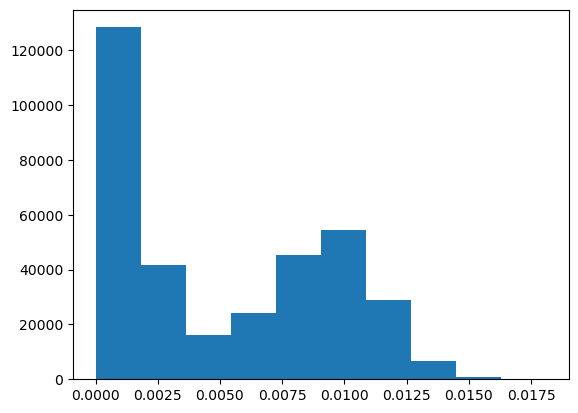

In [4]:
computed_quantities = basis_set.get_output(results['x'])

plt.hist(computed_quantities.mean_intensity.ravel())
plt.show()

mask_threshold = 0.004
mask = computed_quantities.mean_intensity >= mask_threshold

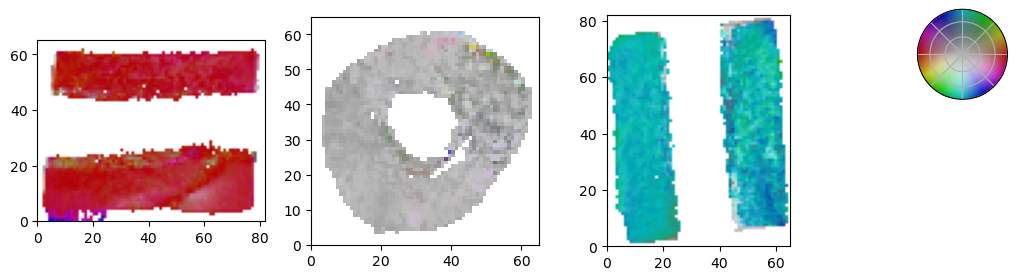

In [5]:
from mumott_plotting.tomogram_plots import plot_direction_in_slice, make_color_wheel
main_direction = computed_quantities.eigenvector_1

fig = plt.figure(figsize = (10,3))

ax = plt.subplot(1,3,1)
ax, _ = plot_direction_in_slice(main_direction, 30, 'yz' , mask=mask, ax = ax)
ax = plt.subplot(1,3,2)
ax, _ = plot_direction_in_slice(main_direction, 40, 'xz' , mask=mask, ax = ax)
ax = plt.subplot(1,3,3)
ax, _ = plot_direction_in_slice(main_direction, 30, 'xy' , mask=mask, ax = ax)

ax = fig.add_subplot([0.9, 0.6, 0.30, 0.30], polar = True)
make_color_wheel(ax)
ax.set_xticklabels([]); ax.set_yticklabels([])
plt.show()
